# Neuronky projekt 2

In [1]:
using PyPlot
using Images
using PyCall
@pyimport numpy as np 
@pyimport numpy.linalg as LA

## Functions

In [177]:
# normalization
function normalize(data)
    x = mean(data)
    data -= x
    σ = maximum(data) - minimum(data)
    data /= σ
    return data, x, σ
end

# de-normalization
function denormalize(data, x, σ)
    data *= σ
    data += x
    return data
end

# Partition of data -> (i,j)th place
function partition(data, s, i, j)
    part = data[ s*(i-1) + 1 : s*i , s*(j-1) + 1 : s*j ]
    return part
end

# Insert partition into new dataset
function insert(data_new, part_new, i, j)
    data_new[ s*(i-1) + 1 : s*i , s*(j-1) + 1 : s*j ] = part_new
    return data_new
end  

# Stitching all partitions into new dataset
function stitch(img, P)
    (data, x, σ) = normalize(img)
    data = Array{Float64}(data)
    
    data_new = np.zeros((Height,Width))
    println("Stitching")

    for i=1:N_h
        for j = 1:N_w
            part = partition(data, s, i, j)
            X = reshape(part, (s^2,1))
            if (length(P) == 64)
                X_new = P * dot(P,X)
            else
                X_new = P' * P * X
            end
            part_new = reshape(X_new, (s,s))
            data_new = insert(data_new, part_new, i, j)
        end
    end
    img_new = denormalize(data_new, x, σ)
    if (minimum(img_new) < 0) img_new -= minimum(img_new) end
    if (maximum(img_new) > 1) img_new /= maximum(img_new) end
    
    return img_new
end

# eigenvalues calculation
function eigen(img,P)
    (data, x, σ) = normalize(img)
    Mcorr = zeros(s^2,s^2)
    for i=1:N_h
        for j = 1:N_w
            part = partition(data, s, i, j)
            X = reshape(part, (s^2,1))
            X = P' * P * X
            Mcorr += X*X' / (Height*Width)
        end
    end
    w,v = LA.eig(Mcorr)
    return w,v
end

eigen (generic function with 1 method)

) in module Main at In[75]:12 overwritten at In[177]:12.


## Data import and preprocessing

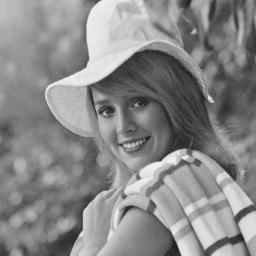

In [3]:
img = imread("elaine.png")

Height, Width = size(img)
s = 8
N_h = Int(Height/s)
N_w = Int(Width/s)

colorview(Gray, img)

## APEX algorithm

In [4]:
function APEX(img, s, P, W, α, epochs, m)
    
    (data, x, σ) = normalize(img)
    data = Array{Float64}(data)
    
    Y = zeros(m)
    β = γ = α
    
    for n=randperm(N_h*N_w)
        i = div(n-1,N_w) + 1
        j = (n-1)%N_w + 1
    
        part = partition(data, s, i, j)
        
        X = reshape(part, (s^2,1))
        
        if (m==1)  # Oja's part
            Y[1] = dot(P[1,:], X)
            P[1,:] += β * (Y[1]*X - (Y[1])^2 * P[1,:])
        else 
            Y[1:m] = P[1:m,:] * X
            Y[m] += dot(W[1:m-1], Y[1:m-1])
            
            P[m,:] += β * (Y[m]*X - (Y[m])^2 * P[m,:])
            W[1:m-1] -= γ * (Y[m]*Y[1:m-1] + (Y[m])^2 * W[1:m-1])
        end
    end
    
    return P, W
end

APEX (generic function with 1 method)

## Training

In [34]:
# Three PCs are already found by previous calculation

α = 1e-3  # step = aprrox 1/(N_h * N_w)
ϵ = 1e-3  # initialization parameter
epochs = 5000
M=20  # number of PCs

P = ϵ * ( 2*rand(M, s^2) - 1)  
println("Compressing...")

for m = 1:5
    W = ϵ * ( 2*rand(m-1))
    println("Finding PC $m :")
    
    for ep=1:epochs    
        if (ep%500 == 0) println("Starting epoch $ep, W=$(mean(W))") end  #mean(W) is my testing parameter
        P, W = APEX(img, s, P, W, α, epochs, m)
        
    end
end

Compressing...
Finding PC 4 :
Starting epoch 500, W=-0.13525010673951718
Starting epoch 1000, W=-0.13210856986987787
Starting epoch 1500, W=-0.13204913104423163
Starting epoch 2000, W=-0.13236007405187547
Starting epoch 2500, W=-0.13213202398427154
Starting epoch 3000, W=-0.13208587983797102
Starting epoch 3500, W=-0.13170758318054096
Starting epoch 4000, W=-0.13177169633749833
Starting epoch 4500, W=-0.1322129729592715
Starting epoch 5000, W=-0.13204476182595004
Finding PC 5 :
Starting epoch 500, W=-0.6730809155830211
Starting epoch 1000, W=-0.6719273505529401
Starting epoch 1500, W=-0.6730921259651286
Starting epoch 2000, W=-0.6722568482523714
Starting epoch 2500, W=-0.6726452533472812
Starting epoch 3000, W=-0.6725223586929531
Starting epoch 3500, W=-0.6730633258057361
Starting epoch 4000, W=-0.6734286822442951
Starting epoch 4500, W=-0.6721830407023768
Starting epoch 5000, W=-0.6723270904908664
Finding PC 6 :
Starting epoch 500, W=0.0019134467825126134
Starting epoch 1000, W=0.0021

## Testing properties of PCs

Eigenvectors scalar products (should = 1):
1.00018
1.00075
1.00476
1.12054
6.66744
0.99481
0.99392
0.99425
0.99321
0.99388
0.99376
0.99364
0.99469
0.99436
0.99381
0.99409
0.99497
0.99844
1.83146
1.64892
...
Eigenvectors visualization:


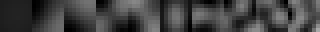

In [197]:
println("Eigenvectors scalar products (should = 1):")
prod = zeros(M)
for i=1:M
    prod[i] = round( dot(P[i,:],P[i,:]), 5)
    println("$(prod[i])")
end
println("...")

println("Eigenvectors visualization:")
eigenfull = np.zeros((s,10*s))
(data, x, σ) = normalize(img)
for n=1:10
    eigenvec = reshape(P[n,:], (s,s)) 
    if (minimum(eigenvec) < 0) eigenvec -= minimum(eigenvec) end
    if (maximum(eigenvec) > 1) eigenvec /= maximum(eigenvec) end
    eigenfull[:, s*(n-1)+1:s*n] = eigenvec
end
#save("eigens.png", eigenfull)
colorview(Gray, eigenfull)

## Covariance matrix and eigenvalues

In [198]:
w,v = eigen(img, eye(s^2))
wnew,vnew = eigen(img, Pnew)
println(real(w[1:10]))
println(real(wnew[1:10]))

[0.0348016,0.00286692,0.00221442,0.0008043,0.000575745,0.000300495,0.000217004,0.000176011,0.000115864,0.000101551]
[0.0353889,0.00286985,0.00218128,0.000569704,0.000296839,0.000214499,0.000173612,6.64324e-5,9.23688e-5,0.000100428]


## Reconstruction

Stitching
Error measured: 55.25057727358878


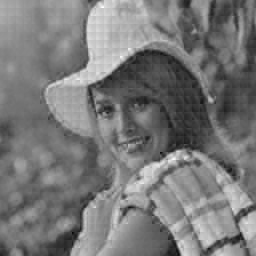

In [180]:
# Manual selecting good PCs according to test above
good = [1,2,3,6,7,8,9,10,11,12,13]
Pnew = P[good,:]
pic = stitch(img, Pnew)
error = 10^4 * sum((img - pic).^2) / (Width*Height)
println("Error measured: $error")
#save("NNelaine.png", pic)
colorview(Gray, pic)

In [1]:
Width

LoadError: UndefVarError: Width not defined

## Applying Pnew on another pictures

Stitching
Error measured: 841.7127408085947


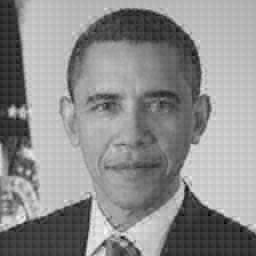

In [181]:
obama = imread("obama.png")

new = stitch(obama, Pnew)

error = 10^4 * sum((img - new).^2) / (Width*Height)
println("Error measured: $error")
#save("NNgirl.png", new)
colorview(Gray, new)